In [23]:
from pdfminer.high_level import extract_text, extract_pages
import fitz  # PyMuPDF
from urlextract import URLExtract
import re
import sys
import string
from urllib.parse import urlparse
from tldextract import extract
import requests
import socket
import mimetypes
import os
import pandas as pd
import tldextract
from urllib.parse import unquote
from bs4 import BeautifulSoup
import hashlib
import whois
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [16]:
""" Extraction Phase """

#Method used for extrating URIs from plain text from pdf pages
def extract_textlinks(pdf_file_path, page_number, df_all_links):
    print(f"Extracting textlinks from page {page_number} ...")
    count = 0
    
    text = extract_text(pdf_file_path, page_numbers=[page_number])
    initial_text = text
    text = text.replace("\r", "")
    text = text.replace("\r\n", "")
    #print("before: "+text)
    extractor = URLExtract()
    final_links = []
    # m1
    text = text.replace("\n", "")
    links = extractor.find_urls(text)
    final_links.extend(links)
    
    # m2
    link_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+[^\\s"\'\[\]\(\),.]', re.MULTILINE)
    links_extra = link_pattern.findall(text)
    final_links.extend(links_extra)
    
    # m3
    extra_text = initial_text.replace("\n", " ")
    links_extra2 = extractor.find_urls(extra_text)
    final_links.extend(links_extra2)
    
    # m4
    link_pattern2 = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+[^\\s"\'\[\]\(\),.]', re.MULTILINE)
    links_extra3 = link_pattern2.findall(extra_text)
    final_links.extend(links_extra3)
    
    final_links = list(set([j.strip() for j in final_links]))
    final_links = remove_subsets(final_links)
    
    if final_links is not None:
        for link in final_links:
            count += 1
            print(f"[{count}] URL Found:", link)
            df_page = pd.DataFrame({'Links': [link]})
            df_page['Page'] = page_number
            df_page['DocumentID'] = os.path.basename(pdf_file_path)
            df_page['LinkType'] = 'textlink'
            df_all_links = pd.concat([df_all_links, df_page], ignore_index=True, axis=0)
    
    print("[*] Total textlinks extracted:", count)  
    return df_all_links

#Method used for extracting hyperlinks from pdf pages
def extract_hyperlinks(pdf_file_path, page_number, df_all_links):
    print(f"Extracting hyperlinks from page {page_number} ...")
    count = 0
    
    doc = fitz.open(pdf_file_path)
    page = doc[page_number]
    links = page.get_links()
    
    if links is not None:
        for link in links:
            if 'uri' in link:
                count += 1
                print(f"[{count}] URL Found:", link['uri'])
                df_page = pd.DataFrame({'Links': [link['uri']]})
                df_page['Page'] = page_number
                df_page['DocumentID'] = os.path.basename(pdf_file_path)
                df_page['LinkType'] = 'hyperlink'

                df_all_links = pd.concat([df_all_links, df_page], ignore_index=True, axis=0)
                
    print("[*] Total hyperlinks extracted:", count)
    
    return df_all_links

def remove_subsets(input_list):
    result_list = []
    def custom_sort(s):
        return (-len(s), s)
    sorted_list = sorted(input_list, key=custom_sort)
    for current_element in sorted_list:
        is_subset = False

        for result_element in result_list:
            if current_element.startswith(result_element):
                is_subset = True
                break

        if not is_subset:
            result_list.append(current_element)

    return result_list

def process_pdf(pdf_file_path):
    df_all_links = pd.DataFrame(columns=['Links', 'Page', 'DocumentID', 'LinkType'])
    #df_all_links = pd.DataFrame(columns=['Links', 'Page', 'DocumentID'])
    start_page = 0
    end_page = len(list(extract_pages(pdf_file_path)))

    for page_num in range(start_page, end_page):
        df_all_links = extract_textlinks(pdf_file_path, page_num, df_all_links)
        df_all_links = extract_hyperlinks(pdf_file_path, page_num, df_all_links)

    return df_all_links

# Specify the PDF directory path
pdf_file_path = 'threat_reports/'

output_folder = os.path.join(os.getcwd(), 'extraction_phase')
os.makedirs(output_folder, exist_ok=True)

for f in os.listdir(pdf_file_path):
    print(f"Extracting threat references from file {f} ...")
    result_df = process_pdf(pdf_file_path + f)
    
    # display the final DataFrame
    print(f"{len(result_df)} threat references found in total from document {f}")
    print(result_df.head())

    # export the DataFrame to a CSV file in the root folder
    file_name_without_extension = os.path.splitext(f)[0]
    csv_file_path = os.path.join(output_folder, f'{file_name_without_extension}_extracted.csv')
    result_df.to_csv(csv_file_path, index=False)
    print(f'DataFrame exported to: {csv_file_path}')

Extracting threat references from file aa23-025a-protecting-against-malicious-use-of-rmm-software.pdf ...
Extracting textlinks from page 0 ...
[1] URL Found: cisa.gov/tlp/.
[*] Total textlinks extracted: 1
Extracting hyperlinks from page 0 ...
[1] URL Found: mailto:report@cisa.gov
[2] URL Found: mailto:Cybersecurity_Requests@nsa.gov
[3] URL Found: https://cisa.gov/tlp
[*] Total hyperlinks extracted: 3
Extracting textlinks from page 1 ...
[*] Total textlinks extracted: 0
Extracting hyperlinks from page 1 ...
[1] URL Found: https://www.cisa.gov/uscert/sites/default/files/publications/AA23-025A.stix.xml
[2] URL Found: https://www.cisa.gov/einstein
[3] URL Found: https://www.silentpush.com/blog/silent-push-uncovers-a-large-phishing-operation-featuring-amazon-geek-squad-mcafee-microsoft-norton-and-paypal-domains
[4] URL Found: https://www.silentpush.com/blog/silent-push-uncovers-a-large-phishing-operation-featuring-amazon-geek-squad-mcafee-microsoft-norton-and-paypal-domains
[*] Total hyper

In [63]:
""" Cleaning Step """

sys.setrecursionlimit(10000)
def clean_links(df):
    indices_to_remove = []
    df['Links'] = df['Links'].str.rstrip()
    df['Links'] = df['Links'].apply(string_split)
    #df['Links'] = df['Links'].apply(remove_after_extension)
    # Remove duplicates
    df['Links'] = df['Links'].apply(remove_dots_at_end)
    df['Links'] = df['Links'].apply(remove_commas_at_end)
    df.drop_duplicates(subset=['Links', 'Page'], keep='first', inplace=True)
    
    """
    Groups links by 'Page' and creates temporary lists for each group.
    """

    # Group by 'Page' and 'LinkType'
    grouped_df = df.groupby(['Page'])
    # Iterate over each group
    for _, group_df in grouped_df:
        # Iterate over each pair of URLs in the group
        for idx1, row1 in group_df.iterrows():
            for idx2, row2 in group_df.iterrows():
                if idx1 != idx2 and (idx1 not in indices_to_remove or idx2 not in indices_to_remove):
                    if len(row1['Links']) < len(row2['Links']) and row1['Links'] in row2['Links']:
                        if row2['Links'].startswith(row1['Links']):
                            print('comparing: ' + row2['Links'])
                            print('with: ' + row1['Links'])
                            indices_to_remove.append(idx1)
                            print('dropped: ' + row1['Links'])
                        elif not is_valid_url(row1['Links']) and row2['Links'].endswith(row1['Links']):
                            print('comparing: ' + row2['Links'])
                            print('with: ' + row1['Links'])
                            indices_to_remove.append(idx1)
                            print('dropped: ' + row1['Links'])
                    if len(row2['Links']) < len(row1['Links']) and row2['Links'] in row1['Links']:
                        if row1['Links'].startswith(row2['Links']):
                            print('comparing: ' + row1['Links'])
                            print('with: ' + row2['Links'])
                            indices_to_remove.append(idx2)
                            print('dropped: ' + row2['Links'])
                        elif not is_valid_url(row2['Links']) and row1['Links'].endswith(row2['Links']):
                            print('comparing: ' + row1['Links'])
                            print('with: ' + row2['Links'])
                            indices_to_remove.append(idx2)
                            print('dropped: ' + row2['Links'])   
    # Drop the rows with indices in the list
    df.drop(indices_to_remove, inplace=True)
    
    return df

def remove_dots_at_end(cell_value):
    if isinstance(cell_value, str):
        return cell_value.rstrip('.')
    else:
        return cell_value

def remove_commas_at_end(cell_value):
    if isinstance(cell_value, str):
        return cell_value.rstrip(',')
    else:
        return cell_value

def string_split(string):
    sign = '/\.|/,|/\(|/\)|/\['
    newString = re.split(sign,string)[0]
    
    if len(string) == len(newString) :
        return string
    elif len(string) - len(newString) < 10:
        return re.split(sign,string)[0] + "/"
    else:
        return string

# Specify the PDF directory path
pdf_file_path2 = 'extraction_phase/'

output_folder2 = os.path.join(os.getcwd(), 'cleaning_phase')
os.makedirs(output_folder2, exist_ok=True)

for f2 in os.listdir(pdf_file_path2):
    print(f"Cleaning threat references from file {f2} ...")
    total = len(pd.read_csv(pdf_file_path2 + f2))
    result_df2 = clean_links(pd.read_csv(pdf_file_path2 + f2))
    
    # display the final DataFrame
    print(f"{len(result_df2)} out of {total} threat references remaining after cleaning from document {f2}")
    print(result_df2.head())
    
    # export the DataFrame to a CSV file in the root folder
    file_name_without_extension2 = os.path.splitext(f2)[0]
    if file_name_without_extension2.endswith('_extracted'):
        file_name_without_extension2 = file_name_without_extension2.rstrip('_extracted')
    csv_file_path2 = os.path.join(output_folder2, f'{file_name_without_extension2}_cleaned.csv')
    result_df2.to_csv(csv_file_path2, index=False)
    print(f'DataFrame exported to: {csv_file_path2}')

Cleaning threat references from file aa23-025a-protecting-against-malicious-use-of-rmm-software_extracted.csv ...
comparing: cisa.gov/cyber-hygiene-services
with: cisa.gov/cyber-
dropped: cisa.gov/cyber-
comparing: https://www.cisa.gov/cyber-hygiene-services
with: cisa.gov/cyber-hygiene-services
dropped: cisa.gov/cyber-hygiene-services
comparing: https://www.cisa.gov/cyber-hygiene-services
with: cisa.gov/cyber-hygiene-services
dropped: cisa.gov/cyber-hygiene-services
32 out of 51 threat references remaining after cleaning from document aa23-025a-protecting-against-malicious-use-of-rmm-software_extracted.csv
                                               Links  Page  \
0                                      cisa.gov/tlp/     0   
1                             mailto:report@cisa.gov     0   
2              mailto:Cybersecurity_Requests@nsa.gov     0   
3                               https://cisa.gov/tlp     0   
4  https://www.cisa.gov/uscert/sites/default/file...     1   

            

In [75]:
""" Labeling Step """

def label_df(df):
    # Create new columns for 'Domain', 'http_request', 'http_code', and 'mime_type'
    df['Domain'] = None
    df['valid_domain'] = None
    df['valid_tld'] = None
    df['tld'] = None
    df['http_request'] = None
    df['http_code'] = None
    df['mime_type'] = None
    df['whois_info'] = None
    count = 0
    # Iterate over rows
    for index, row in df.iterrows():
        link = row['Links']

        # Extract domain
        domain = extract_domain(link)
        df.at[index, 'Domain'] = domain
        # Check if domain is valid
        if is_valid_domain(domain):
            # If valid, check if URL is valid and get http_request and http_code
            df.at[index, 'whois_info'] = whois_info(domain)
            df.at[index, 'valid_domain'] = True
            df.at[index, 'valid_tld'] = has_valid_tld(domain)[0]
            df['tld'] = has_valid_tld(domain)[1]
            http_request, http_code = is_valid_url(link)
            df.at[index, 'http_request'] = http_request
            df.at[index, 'http_code'] = http_code

            # If http_code is 200, get mime_type
            if http_code == 200:
                mime_type = get_mime_type(link)
                df.at[index, 'mime_type'] = mime_type
        else:
            df.at[index, 'valid_domain'] = False
        count += 1
        print(f'Labeled link {count}/{len(df)}')
    return df

def extract_domain(url):
    # Try using tldextract for extracting domain
    tld_result = extract(url)

    # If tldextract result is not satisfactory, try using urlparse
    if not tld_result.domain or tld_result.suffix == 'co':
        parsed_url = urlparse(url)
        netloc_parts = parsed_url.netloc.split('.')
        
        # Handle special cases based on URL structure
        if len(netloc_parts) > 1:
            if tld_result.suffix == 'co':
                return netloc_parts[0]
            return f"{netloc_parts[-2]}.{netloc_parts[-1]}"

    return f"{tld_result.domain}.{tld_result.suffix}"

#use is_valid_domain to check the result from extract_domain and decide if to proceed with next step and make a http request
def is_valid_domain(domain):
    try:
        # Encode the domain using 'idna' codec
        encoded_domain = domain.encode('idna').decode('utf-8')
        socket.gethostbyname(encoded_domain)
        return True
    except (socket.error, UnicodeError):
        return False

def whois_info(domain):
    try:
        # Query the whois information for the domain
        domain_info = whois.whois(domain)
        # Extract info
        flag = False
        for k in domain_info:
            if domain_info[k] != "null":
                flag = True
        if not flag:
            return None , False  # Unable to determine the status
        else:
            return domain_info , True        
    except whois.parser.PywhoisError:
        return None , False  # Unable to determine the status

def is_valid_url(url, timeout=10):
    try:
        response = requests.get(url, timeout=timeout)
        return response.status_code == 200, response.status_code
    except requests.RequestException:
        return False, None

def has_valid_tld(domain):
    try:
        tld = '.'+tldextract.extract(domain).suffix.lower()
        tlds = pd.read_csv('top-level-domain-names.csv')['Domain'].values
        if tld in tlds:
            return True , tld
        
        
    except Exception as e:
        print(f"An error occurred during domain tld lookup: {e}")   
        return False , None

def get_mime_type(url, timeout=10):
    try:
        response = requests.get(url, stream=True, timeout=timeout)
        response.raise_for_status()

        # Get content type from response headers
        content_type_header = response.headers.get('content-type', '')

        # Use the 'mimetypes' module to guess the MIME type based on the content type
        mime_type, _ = mimetypes.guess_type(url, strict=False)

        # If the content type is not provided in the headers, use the guessed MIME type
        return content_type_header or mime_type

    except requests.RequestException as e:
        print(f"Error retrieving MIME type: {e}")
        return None
    except Exception as e:
        print(f"Error guessing MIME type: {e}")
        return None

# Specify the PDF directory path
pdf_file_path3 = 'cleaning_phase/'

output_folder3 = os.path.join(os.getcwd(), 'labeling_phase')
os.makedirs(output_folder3, exist_ok=True)

for f3 in os.listdir(pdf_file_path3):
    print(f"Labeling links from file {f3} ...")
    result_df3 = label_df(pd.read_csv(pdf_file_path3 + f3))
    
    # display the final DataFrame
    print(result_df3.head())

    # export the DataFrame to a CSV file in the root folder
    file_name_without_extension3 = os.path.splitext(f3)[0]
    if file_name_without_extension3.endswith('_cleaned'):
        file_name_without_extension3 = file_name_without_extension3.rstrip('_cleaned')
    csv_file_path3 = os.path.join(output_folder3, f'{file_name_without_extension3}_labeled.csv')
    result_df3.to_csv(csv_file_path3, index=False)
    print(f'DataFrame exported to: {csv_file_path3}')

Labeling links from file aa23-025a-protecting-against-malicious-use-of-rmm-softw_cleaned.csv ...
Labeled link 1/32
Labeled link 2/32
Labeled link 3/32
Labeled link 4/32
Labeled link 5/32
Labeled link 6/32
Labeled link 7/32
Labeled link 8/32
Labeled link 9/32
Labeled link 10/32
Labeled link 11/32
Labeled link 12/32
Labeled link 13/32
Labeled link 14/32
Labeled link 15/32
Labeled link 16/32
Labeled link 17/32
Labeled link 18/32
Labeled link 19/32
Labeled link 20/32
Labeled link 21/32
Labeled link 22/32
Labeled link 23/32
Labeled link 24/32
Labeled link 25/32
Labeled link 26/32
Labeled link 27/32
Labeled link 28/32
Labeled link 29/32
Labeled link 30/32
Labeled link 31/32
Labeled link 32/32
                                               Links  Page  \
0                                      cisa.gov/tlp/     0   
1                             mailto:report@cisa.gov     0   
2              mailto:Cybersecurity_Requests@nsa.gov     0   
3                               https://cisa.gov/tlp    

In [ ]:
""" Collection Step """

def download_pdf(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Check if the MIME type indicates a PDF
        if response.headers.get('content-type') == 'application/pdf':
            # Extract the PDF content
            pdf_content = response.content
            return pdf_content
        else:
            print(f"Not a PDF: {url}")
            return None

    except requests.RequestException as e:
        print(f"Error downloading PDF: {e}")
        return None

def get_filename_from_url(url):
    parsed_url = urlparse(url)
    path_segments = parsed_url.path.split('/')
    filename = unquote(path_segments[-1])
    if filename.endswith('.pdf'):
        return filename
    else:
        return filename + '.pdf'

def save_pdf(pdf_content, file_path):
    try:
        with open(file_path, 'wb') as pdf_file:
            pdf_file.write(pdf_content)
        print(f"PDF saved to: {file_path}")
    except Exception as e:
        print(f"Error saving PDF: {e}")
    
#TODO: WHOIS Lookup - Use WHOIS lookup services to check domain registration details. Some government domains explicitly list the government entity as the registrant. However, many government organizations use privacy protection services, making it harder to determine ownership.
        
#TODO: Public Suffix List - The Public Suffix List is a community-maintained list of top-level domain suffixes. Some government-owned entities have their own top-level domains (TLDs). Checking against this list might give you an indication.
        
#TODO: Government-Specific TLDs - Some countries have specific top-level domains reserved for government use. For example, ".gov" in the United States. Checking for such TLDs in the URL may provide a clue.Check if the top-level domain is a government-specific TLD
        
#TODO: SSL Certificates - Check the SSL certificate information. Some government websites use SSL certificates issued to their specific government entity.
        
#TODO: Some countries provide official APIs or databases where you can verify if a domain is government-owned. However, not all countries offer this service.

def scrape_links(url):
    try:
        response = requests.get(url)
        response.raise_for_status()

        # Parse the HTML content
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract additional links from the parsed HTML
        links = [a['href'] for a in soup.find_all('a', href=True)]

        return links

    except requests.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return []

def generate_url_id(url):
    # Create a SHA-256 hash object
    sha256 = hashlib.sha256()

    # Update the hash object with the URL bytes
    sha256.update(url.encode('utf-8'))

    # Get the hexadecimal representation of the hash
    url_id = sha256.hexdigest()

    return url_id

# Specify the PDF directory path
pdf_file_path4 = 'labeling_phase/'

# Specify the folder where downloaded PDFs will be saved
output_folder4 = os.path.join(os.getcwd(), 'downloaded_threat_reports')
os.makedirs(output_folder4, exist_ok=True)

# Specify the folder where extracted links will be saved
output_folder5 = os.path.join(os.getcwd(), 'extracted_links_from_websites')
os.makedirs(output_folder5, exist_ok=True)

government_domains = []

# Iterate over files in the PDF directory
for f4 in os.listdir(pdf_file_path4):
    print(f"Downloading PDFs and extracting links with URLs from file {f4} ...")

    # Read the CSV file containing URL information
    result_df4 = pd.read_csv(os.path.join(pdf_file_path4, f4))

    # Initialize the result DataFrame for each file
    downloaded_pdfs_df = pd.DataFrame(columns=['URL', 'Filename', 'DocumentID'])

    # Iterate over rows in the DataFrame
    for i, r in result_df4.iterrows():
        # Extract information from the DataFrame
        mime_type = r.get('mime_type')
        url = r.get('Links')
        domain = r.get('Domain')
        document_id = r['DocumentID']
        file_name_without_extension4 = os.path.splitext(f4)[0]
        if file_name_without_extension4.endswith('_labeled'):
            file_name_without_extension4 = file_name_without_extension3.rstrip('_labeled')
        # Initialize scrapped_links_df for each row
        scrapped_links_df = pd.DataFrame(columns=['Links', 'DocumentID', 'From_PDF'])

        # Check if the MIME type indicates a PDF
        if mime_type == 'application/pdf' and domain in government_domains:# and is_domain_public(domain):
            # Download the PDF and get the local path
            pdf = download_pdf(url)
            file_name = get_filename_from_url(url)
            save_pdf(pdf, os.path.join(output_folder4, file_name))

            # Check if PDF was downloaded successfully
            if pdf is not None:
                print(f'pdf {file_name} downloaded successfully from {url}')
                # Create a dictionary to store information about the downloaded PDF
                new_row = {
                    'URL': url,
                    'Filename': file_name,
                    'DocumentID': document_id
                }
                # Append the new row dictionary to the list
                downloaded_pdfs_df = downloaded_pdfs_df._append(new_row, ignore_index=True)

        elif mime_type == 'text/html' and domain in government_domains:# and is_domain_public(domain):
            # Scrape links and add them to scrapped_links_df
            scrapped_links_rows = scrape_links(url)
            if scrapped_links_rows:
                scrapped_links_df['Links'] = scrapped_links_rows
                scrapped_links_df.loc[scrapped_links_df['Links'].notnull(), 'DocumentID'] = url
                scrapped_links_df.loc[scrapped_links_df['Links'].notnull(), 'From_PDF'] = file_name_without_extension4+'.pdf'

                csv_file_path5 = os.path.join(output_folder5, f'scrapped_links_{generate_url_id(url)}.csv')
                scrapped_links_df.to_csv(csv_file_path5, index=False)
                print(f'Scrapped {len(scrapped_links_df)} links from {url} of file {f4} exported to: {csv_file_path5}')
            else:
                print(f'No scrapped links for {url} of file {f4}')

    # Check if there are downloaded PDFs for the current file
    if not downloaded_pdfs_df.empty:
        # Save the information to a CSV file
        csv_file_path4 = os.path.join(output_folder4, f'downloaded_pdfs_{document_id}.csv')
        downloaded_pdfs_df.to_csv(csv_file_path4, index=False)
        print(f'Downloaded PDF information from {f4} exported to: {csv_file_path4}')
    else:
        print(f'No downloaded PDFs for {f4}') 

#TODO: Main function to run entire pipeline for downloaded pdfs and label the extracted links

In [149]:
def merge_csv_files(folder_path, output_file):
    # Get a list of all CSV files in the specified folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Check if there are any CSV files in the folder
    if not csv_files:
        print("No CSV files found in the specified folder.")
        return

    # Initialize an empty DataFrame to store the merged data
    merged_data = pd.DataFrame()

    # Loop through each CSV file and merge it into the DataFrame
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        df = pd.read_csv(file_path)
        merged_data = pd.concat([merged_data, df], ignore_index=True)

    # Write the merged DataFrame to a new CSV file
    merged_data.to_csv(output_file, index=False)
    print(f"CSV files successfully merged. Merged data saved to '{output_file}'.")

# Example usage:
folder_path = 'extracted_links_from_websites/'
output_file = 'extracted_links_from_websites/merged_data.csv'
merge_csv_files(folder_path, output_file)

CSV files successfully merged. Merged data saved to 'extracted_links_from_websites/merged_data.csv'.


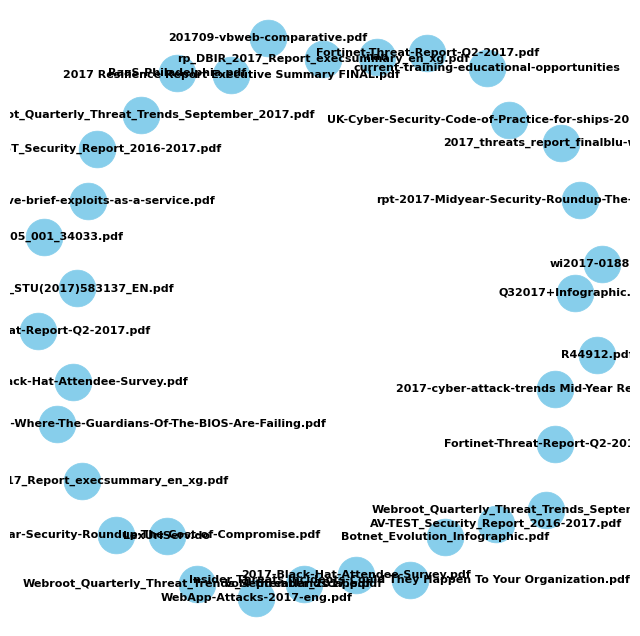

In [80]:
#Specify the PDF directory path
pdf_file_path5 = 'downloaded_threat_reports/'
df = pd.read_csv(pdf_file_path5+'downloaded_pdfs_ENISA Threat Landscape 2017.pdf.csv')

# Ensure 'DocumentID' is treated as an integer column
df['DocumentID'] = pd.to_numeric(df['DocumentID'], errors='coerce')

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in df.iterrows():
    G.add_node(row['DocumentID'], label=row['Filename'], url=row['URL'])
    if not pd.isna(row['DocumentID']) and not pd.isna(row['Filename']):
        G.add_edge(int(row['DocumentID']), row['Filename'])

# Draw the graph
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'label')
urls = nx.get_edge_attributes(G, 'url')

fig, ax = plt.subplots(figsize=(8, 8))

nx.draw(G, pos, with_labels=True, labels={node: G.nodes[node]['label'] for node in G.nodes}, font_size=8, node_size=700, node_color='skyblue', font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5, ax=ax)

# Add hyperlinks to edges
for edge in G.edges():
    x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
    y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
    ax.annotate(f"<a href='{urls[edge]}'>{labels[edge]}</a>", (x, y), color='red', ha='center', va='center')

# Show the graph
plt.show()

In [ ]:
""" Filtering Step """

#Specify the PDF directory path
pdf_file_path4 = 'labeling_phase/'

output_folder4 = os.path.join(os.getcwd(), 'final_phase')
os.makedirs(output_folder4, exist_ok=True)

columns = ['Links', 'Page', 'DocumentID', 'LinkType', 'Domain', 'valid_domain', 'valid_tld', 'http_request', 'http_code', 'mime_type', 'whois_info']
combined_final_df = pd.DataFrame(columns=columns)
enisa_final_df = pd.DataFrame(columns=columns)
aa23_final_df = pd.DataFrame(columns=columns)
csa_final_df = pd.DataFrame(columns=columns)
remaining_final_df = pd.DataFrame(columns=columns)

values_to_exclude = ['aa23-129a_snake_malware_2.pdf','CERTFR-2022-CTI-004.pdf','threat-report-24th-march-2023.pdf']
excluded_list = ['aa23-129a_snake_malware_2_labeled.csv','CERTFR-2022-CTI-004_labeled.csv','threat-report-24th-march-2023_labeled.csv']
joint_list = ['aa23-136a_stopransomware_bianlian_ransomware_group_1_labeled.csv' ,'aa23-165a_understanding_TA_LockBit_0_labeled.csv', 'aa23-187a-increased-truebot-activity-infects-us-and-canada-based-networks_2_labeled.csv','aa23-208a_joint_csa_preventing_web_application_access_control_abus_labeled.csv','aa23-213a_joint_csa_threat_actors_exploiting_ivanti_eppm_vulnerabilities_1_labeled.csv', 'aa23-215a_joint_csa_2022_top_routinely_exploited_vulnerabilities_labeled.csv' , 'aa23-325a_lockbit_3.0_ransomware_affiliates_exploit_cve-2023-4966_citrix_bleed_vulnerability_0_labeled.csv' ,'aa23-335a-irgc-affiliated-cyber-actors-exploit-plcs-in-multiple-sectors_0_labeled.csv' , 'aa23-335a-irgc-affiliated-cyber-actors-exploit-plcs-in-multiple-sectors-1_labeled.csv' , 'aa23-347a-russian-foreign-intelligence-service-svr-exploiting-jetbrains-teamcity-cve-globally_0_labeled.csv' ,'aa23-352a-stopransomware-play-ransomw_labeled.csv', 'apt28-exploits-known-vulnerability-to-carry-out-reconnaissance-and-deploy-malware-on-cisco-routers-uk_labeled.csv','CSA_BLACKTECH_HIDE_IN_ROUTERS_TLP-CLEAR_labeled.csv','CSA_PRC_State_Sponsored_Cyber_Living_off_the_Land_v1.1_labeled.csv','CSA_RANSOMWARE_ATTACKS_ON_CI_FUND_DPRK_ACTIVITIES_labeled.csv']

count = 0

for f4 in os.listdir(pdf_file_path4):
    #print(f"Adding links from file {f4} to:")
    result_df4 = pd.read_csv(pdf_file_path4 + f4)
    complete_final_df = pd.concat([combined_final_df, result_df4], ignore_index=True)
    combined_final_df = complete_final_df[~complete_final_df['DocumentID'].isin(values_to_exclude)]
    
    if 'ENISA' in f4:
        #print('ENISA dataset')
        enisa_final_df = pd.concat([enisa_final_df, result_df4], ignore_index=True)
    elif f4 in joint_list:
        print(f4)
        #print('Joint foreign dataset')
        count +=1
        aa23_final_df = pd.concat([aa23_final_df, result_df4], ignore_index=True)
    elif f4 not in excluded_list:
        #print('Joint US dataset')
        csa_final_df = pd.concat([csa_final_df, result_df4], ignore_index=True)

def has_valid_tld(domain):
    try:
        tld = '.'+tldextract.extract(domain).suffix.lower()
        tlds = pd.read_csv('top-level-domain-names.csv')['Domain'].values
        if tld in tlds:
            return True , tld
        
        
    except Exception as e:
        print(f"An error occurred during domain tld lookup: {e}")   
        return False , None

def fix(df):
    df['tld'] = None
    for index, row in df.iterrows():
        if row['valid_tld'] == True:
            # Assuming has_valid_tld returns a tuple (valid, tld)
            valid, tld = has_valid_tld(row['Domain'])
            if valid:
                df.at[index, 'tld'] = tld
    return df

# export the DataFrame to a CSV file in the root folder
csv_file_path4 = os.path.join(output_folder4, 'combined_all_links.csv')
fix(combined_final_df)
combined_final_df.to_csv(csv_file_path4, index=False)
print(f'DataFrame exported to: {csv_file_path4}')

csv_file_path5 = os.path.join(output_folder4, 'enisa_all_links.csv')
fix(enisa_final_df)
enisa_final_df.to_csv(csv_file_path5, index=False)
print(f'DataFrame exported to: {csv_file_path5}')

csv_file_path6 = os.path.join(output_folder4, 'aa23_all_links.csv')
fix(aa23_final_df)
aa23_final_df.to_csv(csv_file_path6, index=False)
print(f'DataFrame exported to: {csv_file_path6}')

csv_file_path7 = os.path.join(output_folder4, 'csa_all_links.csv')
fix(csa_final_df)
csa_final_df.to_csv(csv_file_path7, index=False)
print(f'DataFrame exported to: {csv_file_path7}')

csv_file_path8 = os.path.join(output_folder4, 'complete_all_links.csv')
fix(complete_final_df)
complete_final_df.to_csv(csv_file_path8, index=False)
print(f'DataFrame exported to: {csv_file_path8}')

folder_path = f'{output_folder4}/images'
os.makedirs(folder_path, exist_ok=True)
print(count)

All threat reports:
Total links: 8604
Filtered percentatge: 96.75732217573221%
Total unique links: 5352
Total unique domains: 1945
                      Domain  Count
0                  mitre.org   1809
1                   cisa.gov    707
2                  europa.eu    414
3                   nist.gov    211
4              microsoft.com    189
5                 github.com    138
6             trendmicro.com    124
7             securelist.com    118
8       bleepingcomputer.com     85
9                    fbi.gov     68
10              symantec.com     62
11              mandiant.com     60
12               defense.gov     51
13              cyber.gov.au     51
14                 zdnet.com     51
15               fireeye.com     43
16                mcafee.com     42
17             wikipedia.org     42
18     talosintelligence.com     41
19            cloudflare.com     40
20           crowdstrike.com     39
21                akamai.com     39
22                   ibm.com     38
23   

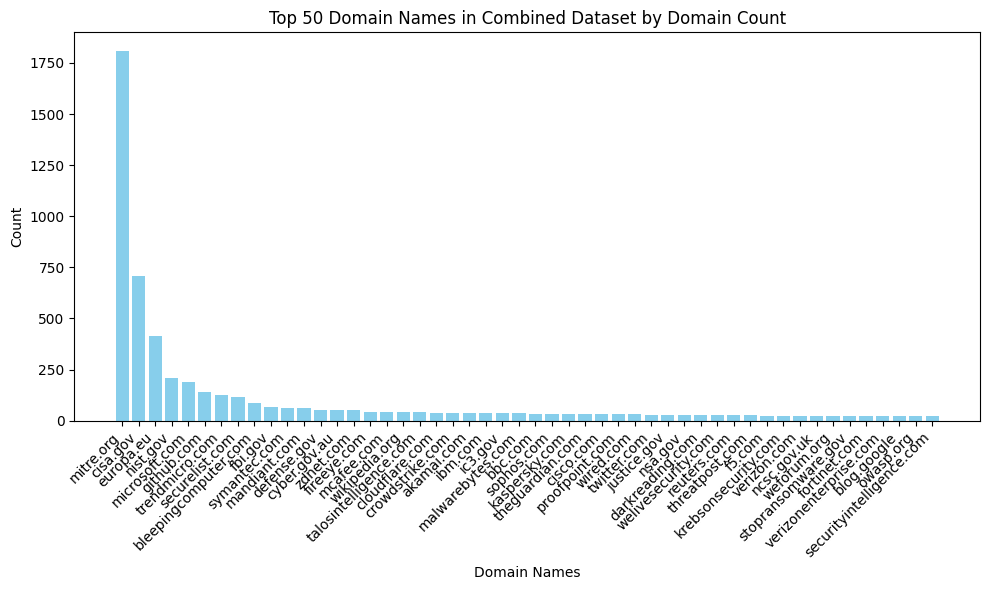

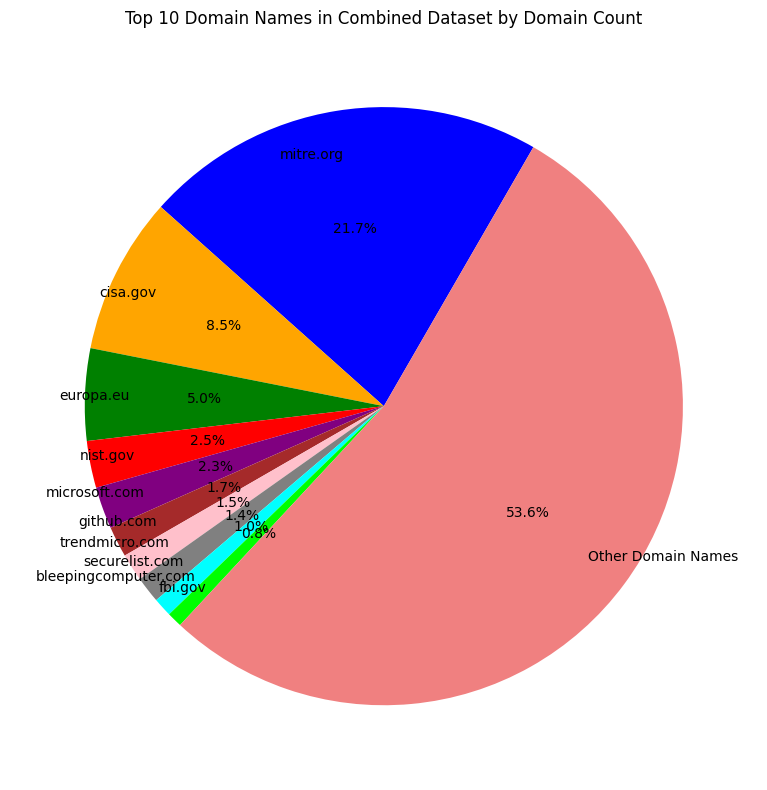

In [185]:
"""Visualisation Step"""
print("All threat reports:")
result1 = pd.read_csv(csv_file_path4)
filtered_result1 = result1[(result1['valid_domain'] == True) & (result1['whois_info'].notna())]
filtered_percentage1 = (len(filtered_result1) / len(result1)) * 100
print(f'Total links: {len(result1)}')
print(f'Filtered percentatge: {filtered_percentage1}%')
l1 = len(filtered_result1['Links'].unique())
l2 = len(filtered_result1['whois_info'].unique())
print(f'Total unique links: {l1}')
print(f'Total unique domains: {l2}')
top_links_with_counts1 = filtered_result1['Domain'].value_counts().head(50).reset_index()
top_links_with_counts1.columns = ['Domain', 'Count']
print(top_links_with_counts1)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_links_with_counts1['Domain'], top_links_with_counts1['Count'], color='skyblue')
plt.xlabel('Domain Names')
plt.ylabel('Count')
plt.title('Top 50 Domain Names in Combined Dataset by Domain Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
# Display the bar chart
plt.savefig(os.path.join(folder_path, 'all_top50domains_bar_chart.png'))
plt.show()

# Create a pie chart
# Get the counts of each unique domain
domain_counts1 = filtered_result1['Domain'].value_counts().reset_index()
domain_counts1.columns = ['Domain', 'Count']
# Get the sum of counts
total_count1 = domain_counts1['Count'].sum()
# Get the top 10 values by count
top_values_with_counts1 = domain_counts1.head(10).copy()
# Create a DataFrame for 'Other' category
other_count1 = domain_counts1.iloc[10:].sum()
other_df1 = pd.DataFrame({'Domain': ['Other Domain Names'], 'Count': [other_count1['Count']]})
# Concatenate the top values and 'Other' DataFrame
final_df1 = pd.concat([top_values_with_counts1, other_df1], ignore_index=True)
# Calculate percentage for each value
final_df1['Percentage'] = (final_df1['Count'] / final_df1['Count'].sum()) * 100
# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'lime', 'lightcoral']
# Create a pie chart with adjusted label distance
plt.figure(figsize=(8, 8))
plt.pie(final_df1['Count'], labels=final_df1['Domain'], autopct='%1.1f%%', startangle=60, labeldistance=0.85, colors=colors)
plt.title('Top 10 Domain Names in Combined Dataset by Domain Count')
plt.tight_layout()
# Display the pie chart
plt.savefig(os.path.join(folder_path, 'all_top10domains_pie_chart.png'))
plt.show()

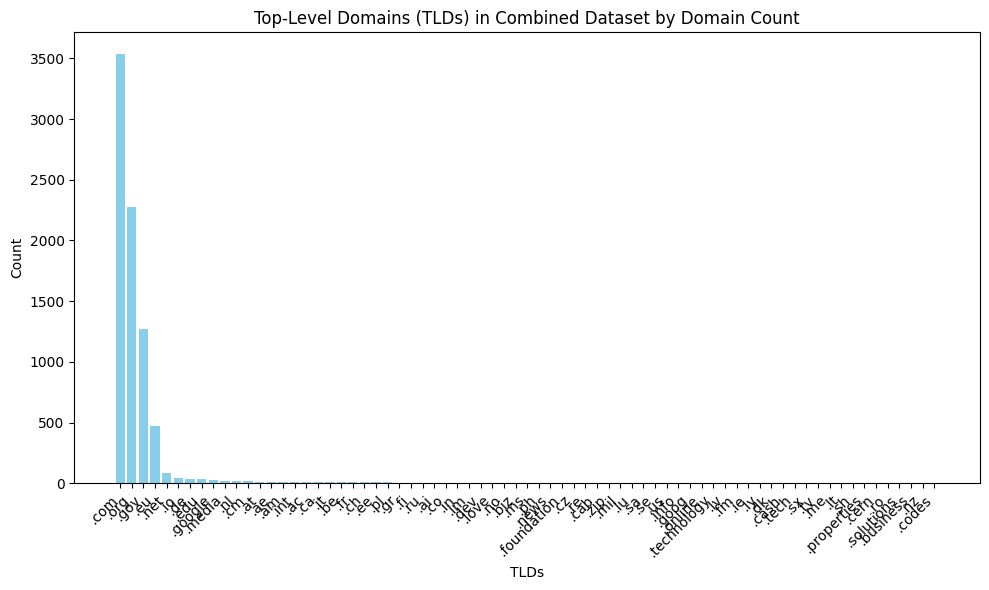

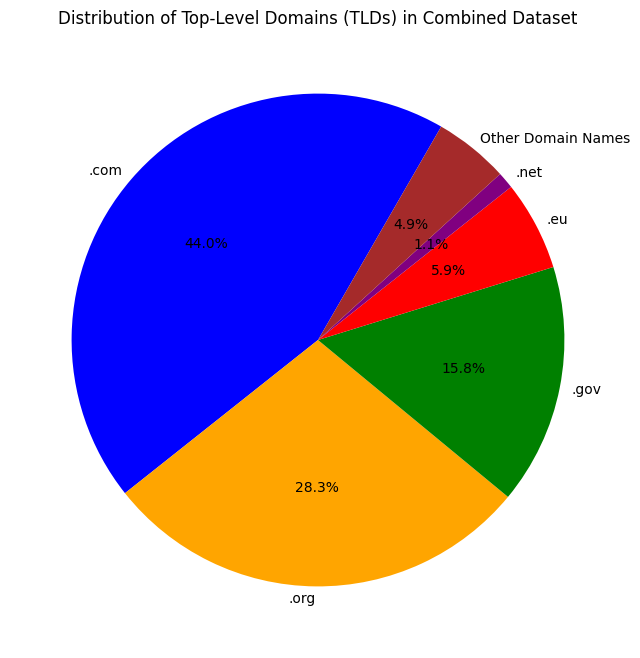

In [186]:
tlds_with_counts = filtered_result1['tld'].value_counts().reset_index()
tlds_with_counts.columns = ['tld', 'Count']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(tlds_with_counts['tld'], tlds_with_counts['Count'], color='skyblue')
plt.xlabel('TLDs')
plt.ylabel('Count')
plt.title('Top-Level Domains (TLDs) in Combined Dataset by Domain Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'tlds_combined_count_bar_chart.png'))
plt.show()

# Calculate percentages for the pie chart
#total_counts = tlds_with_counts['Count'].sum()

# Get the top 5 values by count
top_tlds_with_counts = tlds_with_counts.head(5).copy()

# Create a DataFrame for 'Other' category
other_tlds_with_counts = tlds_with_counts.iloc[5:].sum()
other_tlds_with_counts = pd.DataFrame({'tld': ['Other Domain Names'], 'Count': [other_tlds_with_counts['Count']]})

# Concatenate the top values and 'Other' DataFrame
final_tlds_with_counts = pd.concat([top_tlds_with_counts, other_tlds_with_counts], ignore_index=True)

# Calculate percentage for each value
final_tlds_with_counts['Percentage'] = (final_tlds_with_counts['Count'] / final_tlds_with_counts['Count'].sum()) * 100

# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(final_tlds_with_counts['Count'], labels=final_tlds_with_counts['tld'], autopct='%1.1f%%', startangle=60,labeldistance=1.05, colors=colors)
plt.title('Distribution of Top-Level Domains (TLDs) in Combined Dataset')

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'tlds_combined_distribution_pie_chart.png'))

# Display the plot
plt.show()

ENISA threat reports:
Total links: 5393
Filtered percentage: 96.94047839792323%
Total unique links: 4108
Total unique domains: 1832
                      Domain  Count
0                  europa.eu    414
1                  mitre.org    409
2             securelist.com    118
3             trendmicro.com    116
4              microsoft.com     92
5       bleepingcomputer.com     74
6               symantec.com     62
7               mandiant.com     52
8                  zdnet.com     51
9                   cisa.gov     51
10               fireeye.com     43
11             wikipedia.org     42
12            cloudflare.com     40
13                mcafee.com     40
14                akamai.com     39
15                   ibm.com     38
16     talosintelligence.com     36
17                   bbc.com     35
18           crowdstrike.com     35
19             kaspersky.com     33
20          malwarebytes.com     33
21                  nist.gov     33
22                sophos.com     32
23  

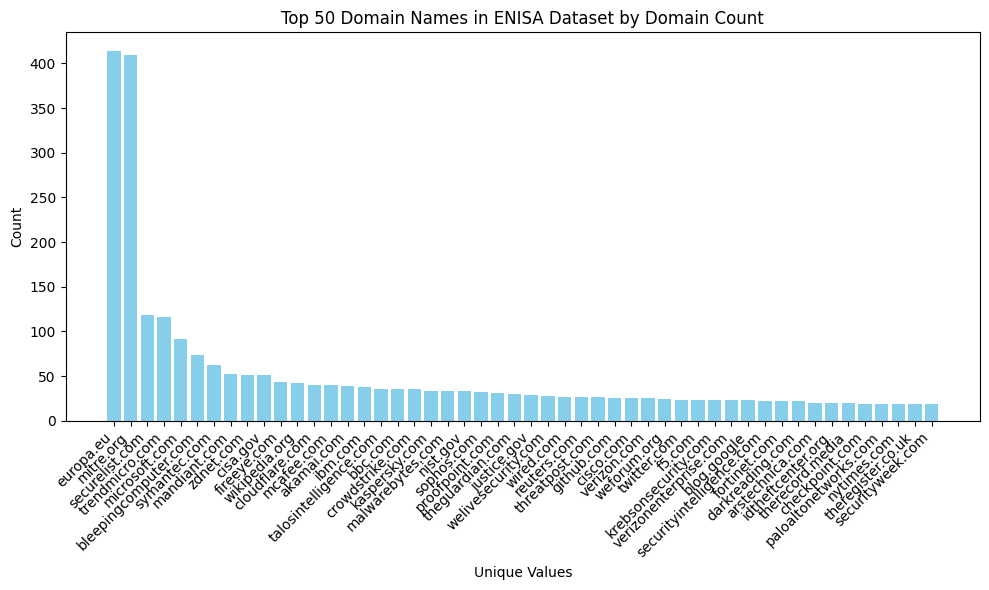

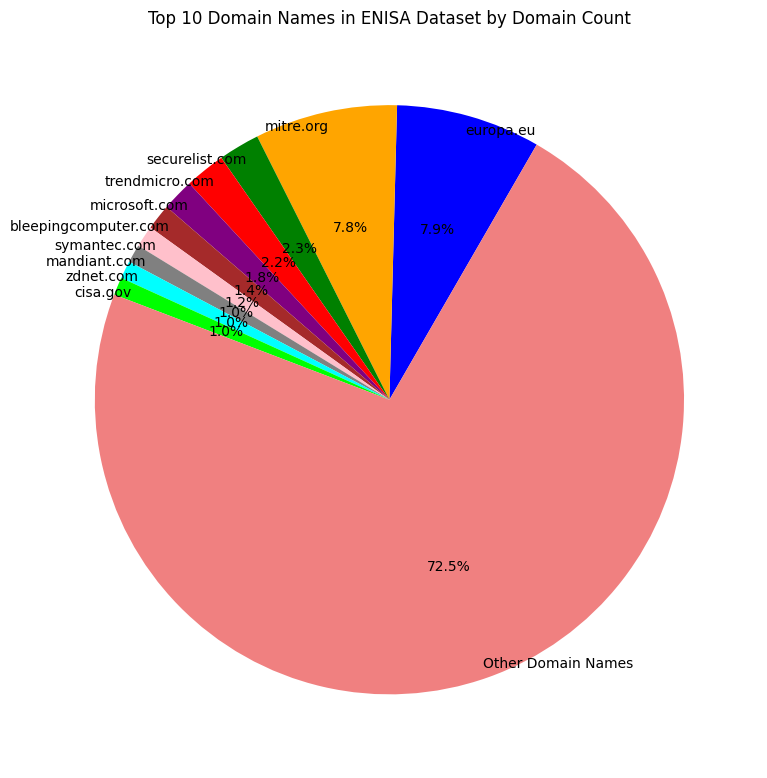

In [187]:
print("ENISA threat reports:")
result2 = pd.read_csv(csv_file_path5)
filtered_result2 = result2[(result2['valid_domain'] == True) & (result2['whois_info'].notna())]
filtered_percentage2 = (len(filtered_result2) / len(result2)) * 100
print(f'Total links: {len(result2)}')
print(f'Filtered percentage: {filtered_percentage2}%')
l3 = len(filtered_result2['Links'].unique())
l4 = len(filtered_result2['whois_info'].unique())
print(f'Total unique links: {l3}')
print(f'Total unique domains: {l4}')
top_links_with_counts2 = filtered_result2['Domain'].value_counts().head(50).reset_index()
top_links_with_counts2.columns = ['Domain', 'Count'] 
print(top_links_with_counts2)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_links_with_counts2['Domain'], top_links_with_counts2['Count'], color='skyblue')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Top 50 Domain Names in ENISA Dataset by Domain Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
# Display the bar chart
plt.savefig(os.path.join(folder_path, 'enisa_top50domains_bar_chart.png'))
plt.show()

# Create a pie chart
# Get the counts of each unique domain
domain_counts2 = filtered_result2['Domain'].value_counts().reset_index()
domain_counts2.columns = ['Domain', 'Count']
# Get the sum of counts
total_count2 = domain_counts2['Count'].sum()
# Get the top 10 values by count
top_values_with_counts2 = domain_counts2.head(10).copy()
# Create a DataFrame for 'Other' category
other_count2 = domain_counts2.iloc[10:].sum()
other_df2 = pd.DataFrame({'Domain': ['Other Domain Names'], 'Count': [other_count2['Count']]})
# Concatenate the top values and 'Other' DataFrame
final_df2 = pd.concat([top_values_with_counts2, other_df2], ignore_index=True)
# Calculate percentage for each value
final_df2['Percentage'] = (final_df2['Count'] / final_df2['Count'].sum()) * 100
# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'lime', 'lightcoral']
# Create a pie chart with adjusted label distance
plt.figure(figsize=(8, 8))
plt.pie(final_df2['Count'], labels=final_df2['Domain'], autopct='%1.1f%%', startangle=60, labeldistance=0.95, colors=colors)
plt.title('Top 10 Domain Names in ENISA Dataset by Domain Count')
plt.tight_layout()
# Display the pie chart
plt.savefig(os.path.join(folder_path, 'enisa_top10domains_pie_chart.png'))
plt.show()

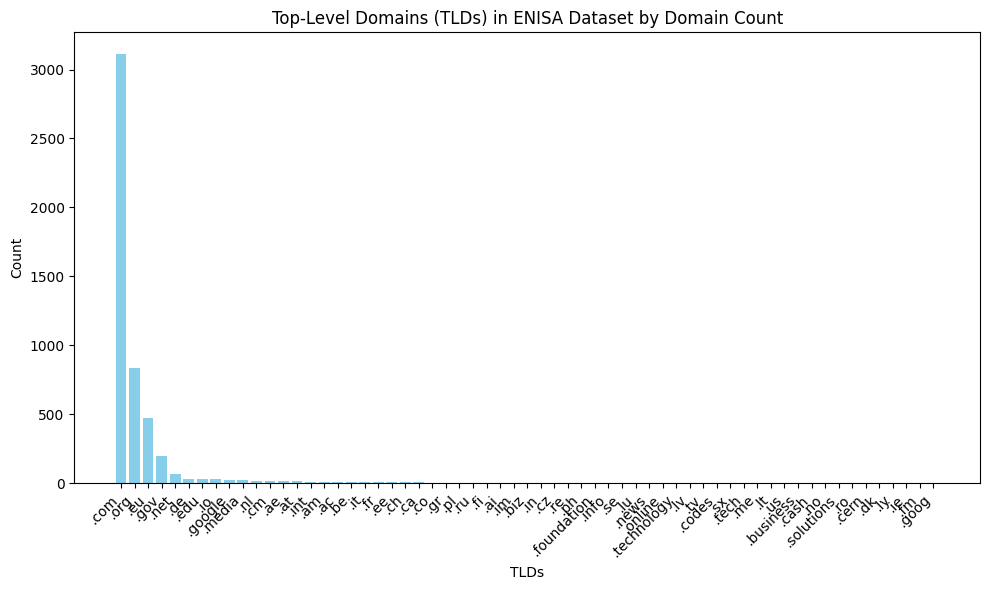

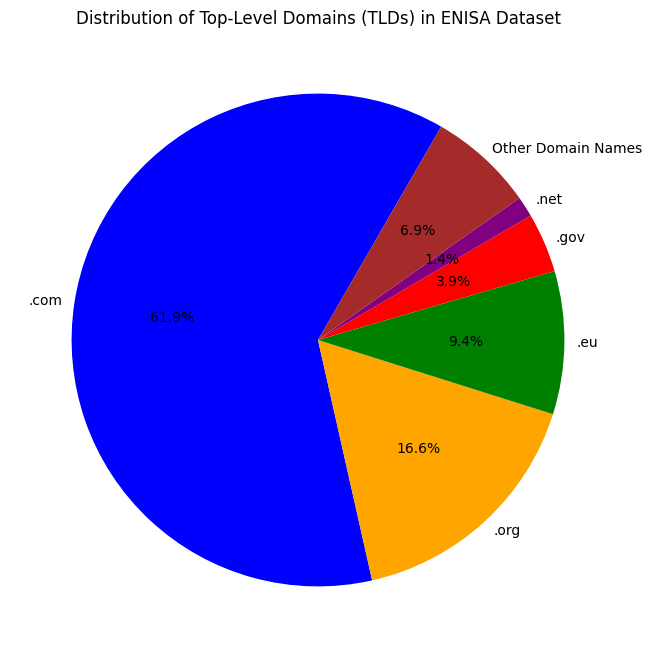

In [195]:
tlds_with_counts1 = filtered_result2['tld'].value_counts().reset_index()
tlds_with_counts1.columns = ['tld', 'Count']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(tlds_with_counts1['tld'], tlds_with_counts1['Count'], color='skyblue')
plt.xlabel('TLDs')
plt.ylabel('Count')
plt.title('Top-Level Domains (TLDs) in ENISA Dataset by Domain Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'tlds_enisa_count_bar_chart.png'))
plt.show()

# Calculate percentages for the pie chart
#total_counts = tlds_with_counts['Count'].sum()

# Get the top 5 values by count
top_tlds_with_counts1 = tlds_with_counts1.head(5).copy()

# Create a DataFrame for 'Other' category
other_tlds_with_counts1 = tlds_with_counts1.iloc[5:].sum()
other_tlds_with_counts1 = pd.DataFrame({'tld': ['Other Domain Names'], 'Count': [other_tlds_with_counts1['Count']]})

# Concatenate the top values and 'Other' DataFrame
final_tlds_with_counts1 = pd.concat([top_tlds_with_counts1, other_tlds_with_counts1], ignore_index=True)

# Calculate percentage for each value
final_tlds_with_counts1['Percentage'] = (final_tlds_with_counts1['Count'] / final_tlds_with_counts1['Count'].sum()) * 100

# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(final_tlds_with_counts1['Count'], labels=final_tlds_with_counts1['tld'], autopct='%1.1f%%', startangle=60,labeldistance=1.05, colors=colors)
plt.title('Distribution of Top-Level Domains (TLDs) in ENISA Dataset')

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'tlds_ENISA_distribution_pie_chart.png'))

# Display the plot
plt.show()

aa23 threat reports:
Total links: 1371
Filtered percentage: 95.91539022611232%
Total unique links: 696
Total unique domains: 120
                   Domain  Count
0               mitre.org    492
1                cisa.gov    267
2                nist.gov    133
3            cyber.gov.au     48
4           microsoft.com     31
5                 fbi.gov     26
6             defense.gov     20
7              github.com     19
8                 nsa.gov     16
9             cyber.gc.ca     10
10            ncsc.gov.uk     10
11         cisecurity.org      9
12                dhs.gov      9
13     stopransomware.gov      9
14         trendmicro.com      8
15             ivanti.com      7
16              cisco.com      7
17        darkreading.com      6
18                ic3.gov      6
19     Stopransomware.gov      5
20   bleepingcomputer.com      5
21              wired.com      4
22          waterisac.org      4
23              owasp.org      4
24         techcrunch.com      4
25      thedf

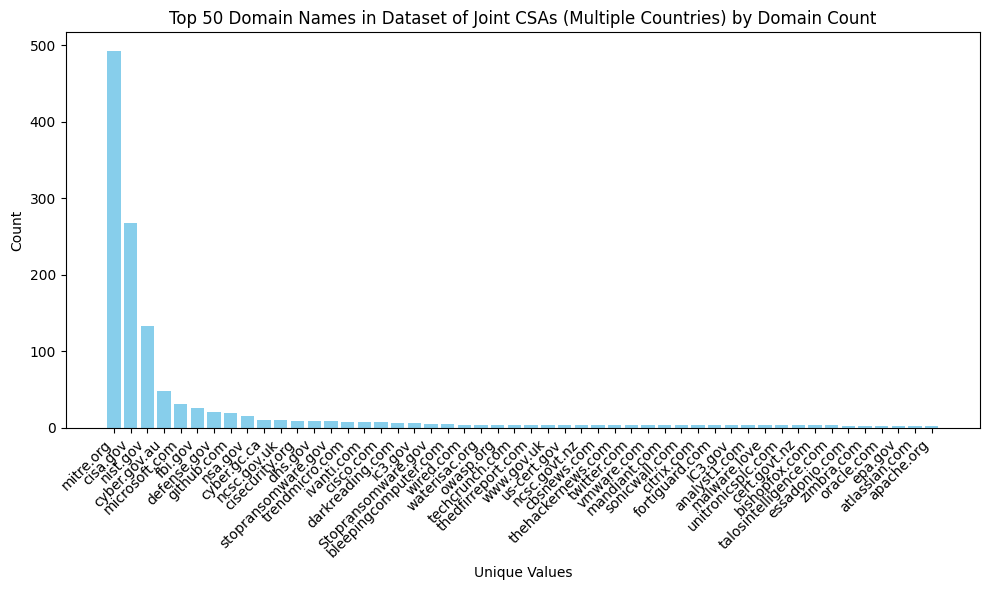

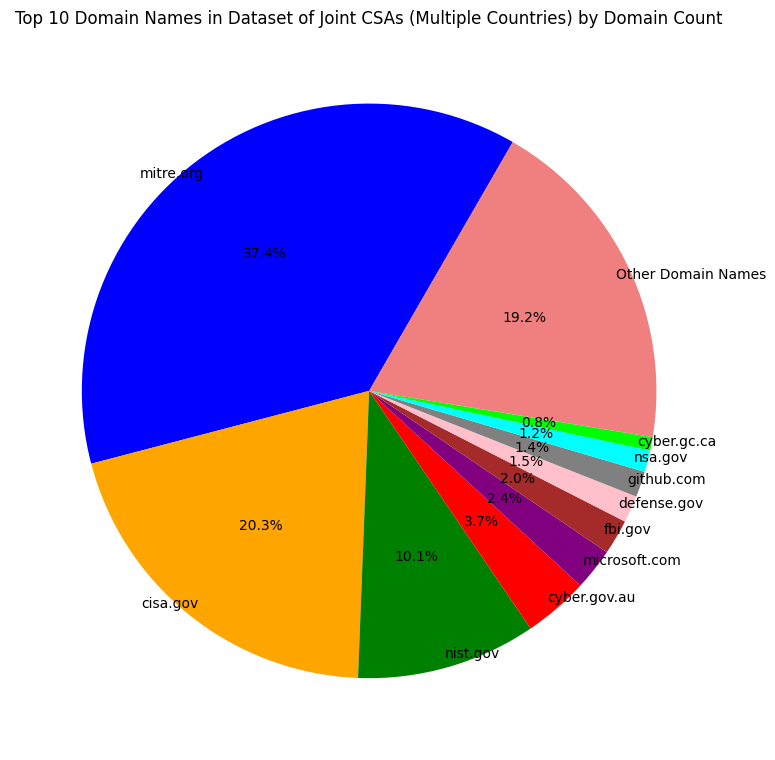

In [189]:
print("aa23 threat reports:")
result3 = pd.read_csv(csv_file_path6)
filtered_result3 = result3[(result3['valid_domain'] == True) & (result3['whois_info'].notna())]
filtered_percentage3 = (len(filtered_result3) / len(result3)) * 100
print(f'Total links: {len(result3)}')
print(f'Filtered percentage: {filtered_percentage3}%')
l5 = len(filtered_result3['Links'].unique())
l6 = len(filtered_result3['whois_info'].unique())
print(f'Total unique links: {l5}')
print(f'Total unique domains: {l6}')
top_links_with_counts3 = filtered_result3['Domain'].value_counts().head(50).reset_index()
top_links_with_counts3.columns = ['Domain', 'Count']
print(top_links_with_counts3)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_links_with_counts3['Domain'], top_links_with_counts3['Count'], color='skyblue')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Top 50 Domain Names in Dataset of Joint CSAs (Multiple Countries) by Domain Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
# Display the bar chart
plt.savefig(os.path.join(folder_path, 'aa23_top50domains_bar_chart.png'))
plt.show()

# Create a pie chart
# Get the counts of each unique domain
domain_counts3 = filtered_result3['Domain'].value_counts().reset_index()
domain_counts3.columns = ['Domain', 'Count']
# Get the sum of counts
total_count3 = domain_counts3['Count'].sum()
# Get the top 10 values by count
top_values_with_counts3 = domain_counts3.head(10).copy()
# Create a DataFrame for 'Other' category
other_count3 = domain_counts3.iloc[10:].sum()
other_df3 = pd.DataFrame({'Domain': ['Other Domain Names'], 'Count': [other_count3['Count']]})
# Concatenate the top values and 'Other' DataFrame
final_df3 = pd.concat([top_values_with_counts3, other_df3], ignore_index=True)
# Calculate percentage for each value
final_df3['Percentage'] = (final_df3['Count'] / final_df3['Count'].sum()) * 100
# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'lime', 'lightcoral']
# Create a pie chart with adjusted label distance
plt.figure(figsize=(8, 8))
plt.pie(final_df3['Count'], labels=final_df3['Domain'], autopct='%1.1f%%', startangle=60, labeldistance=0.95, colors=colors)
plt.title('Top 10 Domain Names in Dataset of Joint CSAs (Multiple Countries) by Domain Count')
plt.tight_layout()
# Display the pie chart
plt.savefig(os.path.join(folder_path, 'aa23_top10domains_pie_chart.png'))
plt.show()

CSA threat reports:
Filtered percentatge: 96.84782608695653%
Total unique links: 746
Total unique domains: 99
                     Domain  Count
0                 mitre.org    908
1                  cisa.gov    389
2                github.com     94
3             microsoft.com     66
4                  nist.gov     45
5                   fbi.gov     36
6               defense.gov     26
7                   ic3.gov     16
8        stopransomware.gov     15
9                   nsa.gov     12
10                  ASP.NET      8
11           cisecurity.org      8
12              us-cert.gov      7
13       Stopransomware.gov      7
14            atlassian.com      6
15     bleepingcomputer.com      6
16                  dhs.gov      6
17             mandiant.com      5
18      emergingthreats.net      5
19               citrix.com      4
20                  IC3.gov      4
21             huntress.com      4
22          crowdstrike.com      4
23           silentpush.com      4
24           cy

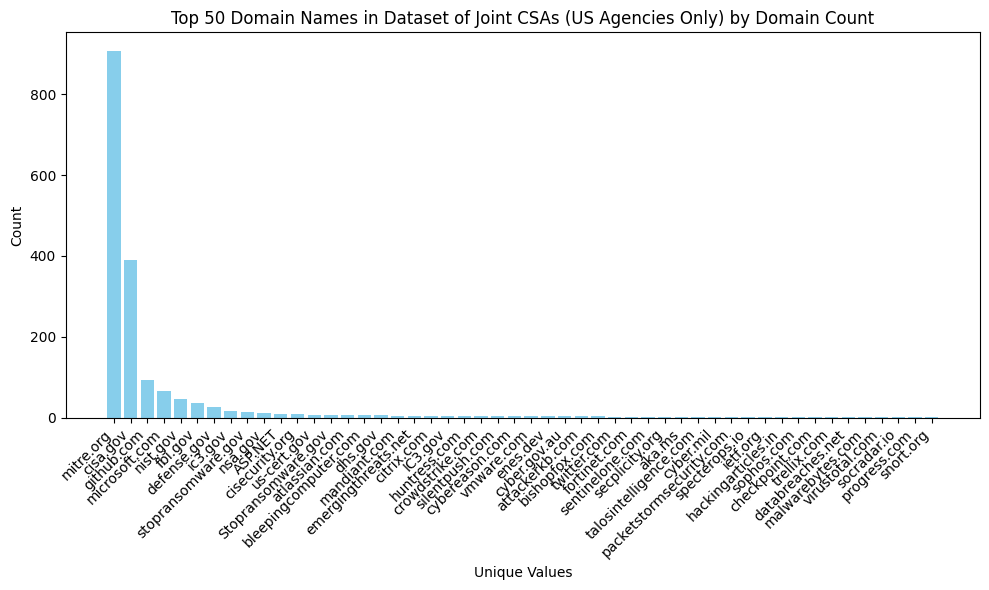

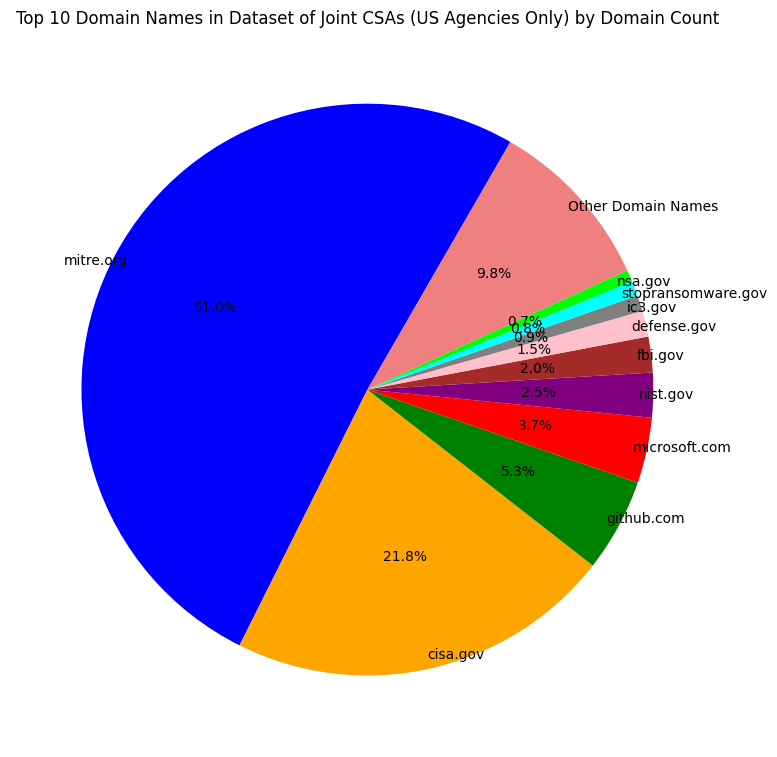

In [190]:
print("CSA threat reports:")
result4 = pd.read_csv(csv_file_path7)
filtered_result4 = result4[(result4['valid_domain'] == True) & (result4['whois_info'].notna())]
filtered_percentage4 = (len(filtered_result4) / len(result4)) * 100
print(f'Filtered percentatge: {filtered_percentage4}%')
l7 = len(filtered_result4['Links'].unique())
l8 = len(filtered_result4['whois_info'].unique())
print(f'Total unique links: {l7}')
print(f'Total unique domains: {l8}')
top_links_with_counts4 = filtered_result4['Domain'].value_counts().head(50).reset_index()
top_links_with_counts4.columns = ['Domain', 'Count']
print(top_links_with_counts4)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_links_with_counts4['Domain'], top_links_with_counts4['Count'], color='skyblue')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Top 50 Domain Names in Dataset of Joint CSAs (US Agencies Only) by Domain Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
# Display the bar chart
plt.savefig(os.path.join(folder_path, 'csa_top50domains_bar_chart.png'))
plt.show()

# Create a pie chart
# Get the counts of each unique domain
domain_counts4 = filtered_result4['Domain'].value_counts().reset_index()
domain_counts4.columns = ['Domain', 'Count']
# Get the sum of counts
total_count4 = domain_counts4['Count'].sum()
# Get the top 10 values by count
top_values_with_counts4 = domain_counts4.head(10).copy()
# Create a DataFrame for 'Other' category
other_count4 = domain_counts4.iloc[10:].sum()
other_df4 = pd.DataFrame({'Domain': ['Other Domain Names'], 'Count': [other_count4['Count']]})
# Concatenate the top values and 'Other' DataFrame
final_df4 = pd.concat([top_values_with_counts4, other_df4], ignore_index=True)
# Calculate percentage for each value
final_df4['Percentage'] = (final_df4['Count'] / final_df4['Count'].sum()) * 100
# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'cyan', 'lime', 'lightcoral']
# Create a pie chart with adjusted label distance
plt.figure(figsize=(8, 8))
plt.pie(final_df4['Count'], labels=final_df4['Domain'], autopct='%1.1f%%', startangle=60, labeldistance=0.95, colors=colors)
plt.title('Top 10 Domain Names in Dataset of Joint CSAs (US Agencies Only) by Domain Count')
plt.tight_layout()
# Display the pie chart
plt.savefig(os.path.join(folder_path, 'csa_top10domains_pie_chart.png'))
plt.show()

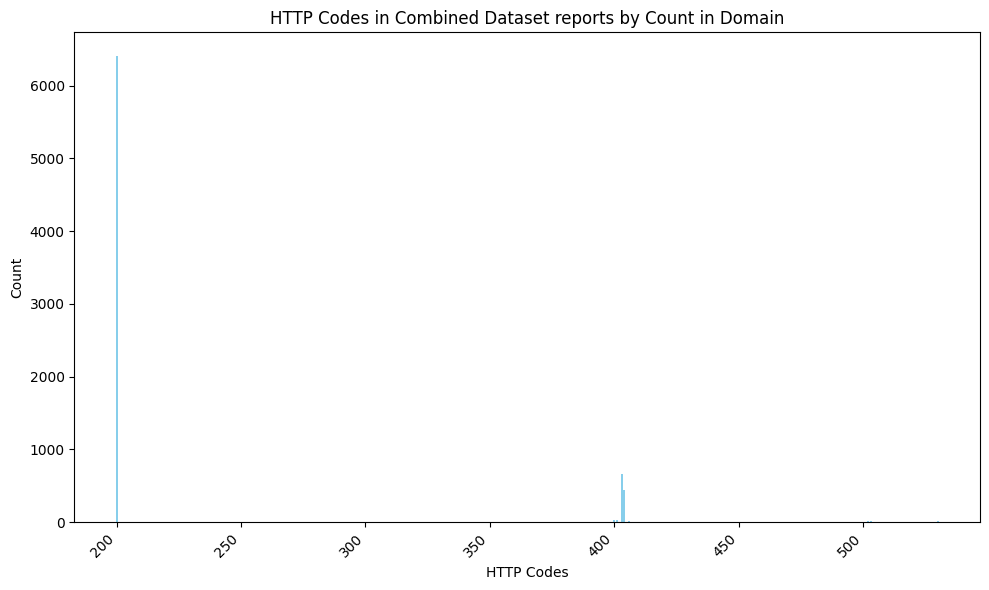

    http_code  Count
0       200.0   6412
1       403.0    668
2       404.0    449
3       400.0     31
4       401.0     27
5       502.0     14
6       406.0     13
7       530.0     13
8       503.0     11
9       410.0      6
10      500.0      5
11      418.0      4
12      521.0      3
13      525.0      2
14      409.0      2
15      526.0      1
16      504.0      1
17      405.0      1
18      429.0      1


C:\Users\admin\PycharmProjects\pythonProject\venv\Lib\site-packages\matplotlib\axes\_axes.py:3219: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = np.asarray(x, np.float32)


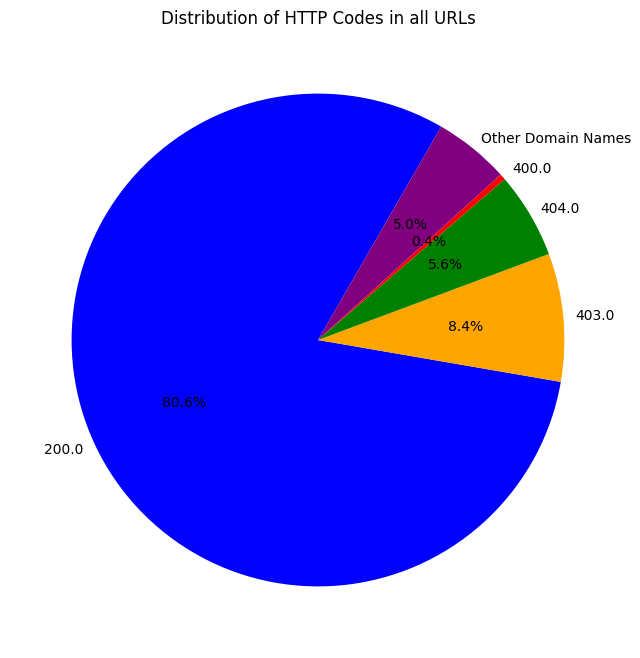

In [191]:
http_codes_with_counts = result1['http_code'].value_counts().reset_index()
http_codes_with_counts.columns = ['http_code', 'Count']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(http_codes_with_counts['http_code'], http_codes_with_counts['Count'], color='skyblue')
plt.xlabel('HTTP Codes')
plt.ylabel('Count')
plt.title('HTTP Codes in Combined Dataset reports by Count in Domain')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'http_codes_count_bar_chart.png'))
plt.show()

# Get the top 5 values by count
top_http_codes_with_counts = http_codes_with_counts.head(4).copy()
print(http_codes_with_counts)
# Create a DataFrame for 'Other' category
other_http_codes_with_counts = http_codes_with_counts.iloc[5:].sum()
other_http_codes_with_counts = pd.DataFrame({'http_code': ['Other Domain Names'], 'Count': [other_tlds_with_counts['Count']]})

# Concatenate the top values and 'Other' DataFrame
final_http_codes_with_counts = pd.concat([top_http_codes_with_counts, other_http_codes_with_counts], ignore_index=True)

# Calculate percentage for each value
final_http_codes_with_counts['Percentage'] = (final_http_codes_with_counts['Count'] / final_http_codes_with_counts['Count'].sum()) * 100

# Specify colors for the pie chart
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(final_http_codes_with_counts['Count'], labels=final_http_codes_with_counts['http_code'], autopct='%1.1f%%', startangle=60,labeldistance=1.05, colors=colors)
plt.title('Distribution of HTTP Codes in all URLs')
folder_path = f'{output_folder4}/images'
os.makedirs(folder_path, exist_ok=True)
# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'http_codes_distribution_pie_chart.png'))

# Display the plot
plt.show()

                                            Mime Type  Count
0                            text/html; charset=utf-8   2758
1                            text/html; charset=UTF-8   1811
2                                     application/pdf    626
3                                           text/html    517
4                             text/html;charset=utf-8    343
5                             text/html;charset=UTF-8    247
6                                            text/xml     19
7                                    application/json     16
8                           text/plain; charset=utf-8     15
9                 text/html, text/html; charset=utf-8      9
10                                         image/jpeg      6
11                            text/html; charset=utf8      5
12                      application/pdf;charset=UTF-8      5
13                           application/octet-stream      5
14                       text/html;charset=ISO-8859-1      4
15                     a

C:\Users\admin\AppData\Local\Temp\ipykernel_18944\4150306876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result1['Merged_Label'] = filtered_result1['mime_type'].apply(lambda x: next((label for label, types in merge_labels.items() if x in types), x))


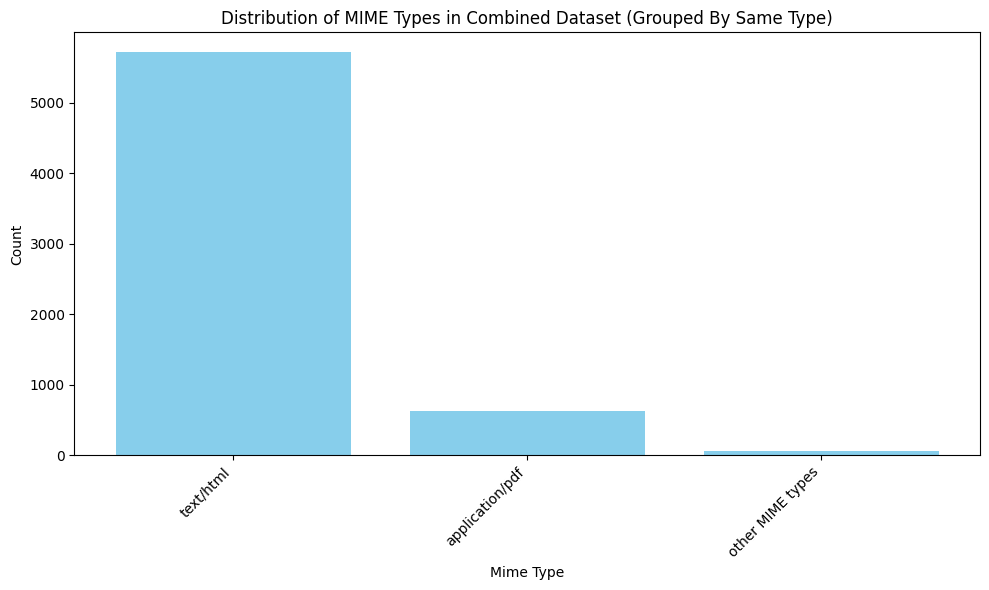

8325


In [192]:
mime_types_with_counts = filtered_result1['mime_type'].value_counts().reset_index()
mime_types_with_counts.columns = ['Mime Type', 'Count']
print(mime_types_with_counts)
#for l in mime_types_with_counts['Mime Type']:
#    print(l)
# Define labels to merge
merge_labels = {'text/html': ['text/html; charset=utf-8', 'text/html; charset=UTF-8', 'text/html;charset=utf-8', 'text/html;charset=UTF-8', 'text/html', 'text/plain; charset=utf-8','text/html, text/html; charset=utf-8', 'text/html; charset=utf8', 'text/html;charset=ISO-8859-1', 'text/html; charset="utf-8"', 'text/html; charset=utf-8; charset=utf8', 'text/html; charset="UTF-8"'],
                'application/pdf': ['application/pdf', 'application/pdf;charset=UTF-8','application/pdf; charset=utf-8'],
                'other MIME types': ['text/xml', 'application/json', 'text/plain; charset=utf-8', 'image/jpeg', 'application/octet-stream', 'application/zip', 'image/png', 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet', 'image/gif', 'text/plain', 'application/x-rpm']}

# Create a new column 'Merged_Label' based on Mime Type and the labels to merge
filtered_result1['Merged_Label'] = filtered_result1['mime_type'].apply(lambda x: next((label for label, types in merge_labels.items() if x in types), x))

# Group by the new 'Merged_Label' column and calculate the counts
mime_types_with_counts = filtered_result1['Merged_Label'].value_counts().reset_index()
mime_types_with_counts.columns = ['Merged Label', 'Count']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(mime_types_with_counts['Merged Label'], mime_types_with_counts['Count'], color='skyblue')
plt.xlabel('Mime Type')
plt.ylabel('Count')
plt.title('Distribution of MIME Types in Combined Dataset (Grouped By Same Type)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'all_mime_types_count_bar_chart.png'))
plt.show()
print(len(filtered_result1))

Domain
europa.eu                    6.329114
eset.com                     3.797468
symantec.com                 3.164557
cloudsecurityalliance.org    2.531646
avg.com.au                   2.531646
weforum.org                  1.898734
technet.com                  1.898734
microsoft.com                1.898734
ahnlab.com                   1.898734
pandasecurity.com            1.898734
f-secure.com                 1.898734
ibm.com                      1.898734
mcafee.com                   1.265823
securelist.com               1.265823
brainyquote.com              1.265823
antiphishing.org             1.265823
scmagazine.com.au            1.265823
akamai.com                   1.265823
thenextweb.com               1.265823
trendmicro.com               1.265823
imperva.com                  1.265823
verizonbusiness.com          1.265823
juniper.net                  1.265823
usenix.org                   1.265823
gtcybersecuritysummit.com    1.265823
techtarget.com               1.265823
mitre

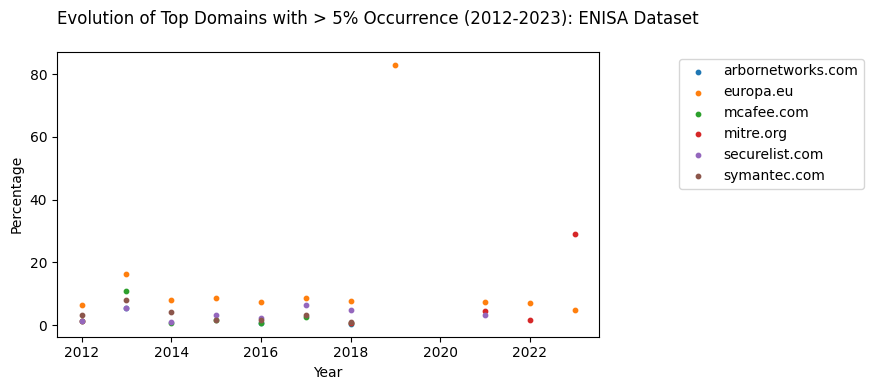

In [193]:
# Assuming you have a list of file paths for each year
file_paths = ['ENISA Threat Landscape 2012_labeled.csv', 'ENISA Threat Landscape 2013_labeled.csv', 'ENISA Threat Landscape 2014_labeled.csv', 'ENISA Threat Landscape 2015_labeled.csv', 'ENISA Threat Landscape 2016_labeled.csv', 'ENISA Threat Landscape 2017_labeled.csv', 'ENISA Threat Landscape 2018_labeled.csv', 'ENISA Threat Landscape 2019_labeled.csv', 'ENISA Threat Landscape 2021_labeled.csv', 'ENISA Threat Landscape 2022_labeled.csv', 'ENISA Threat Landscape 2023_labeled.csv']

# Create a dictionary to store top 5 domains for each year
top_domains_by_year = {}

for file_path in file_paths:
    # Read the CSV file for the current year
    result = pd.read_csv(pdf_file_path4 + file_path)

    # Filter and get the top 5 domains for the current year
    filtered_result = result[(result['valid_domain'] == True) & (result['whois_info'].notna())]
    top_domains = filtered_result['Domain'].value_counts(normalize=True).head(50) * 100  # Convert counts to percentages
    print(top_domains)
    # Extract the year from the file path or adjust based on your data
    year = int((file_path.split(' ')[-1]).split('_')[0])

    # Store the top 5 domains for the current year in the dictionary
    top_domains_by_year[year] = top_domains

# Create a DataFrame from the dictionary
top_domains_df = pd.DataFrame(top_domains_by_year)

# Plot the evolution of the top 5 domains as percentages
plt.figure(figsize=(10, 4))
already_in_plot = []
count = 0
for domain in top_domains_df.index:
    counts = top_domains_df.loc[domain]
    
    # Exclude labels for lines where the maximum count is below a threshold (e.g., 15)
    if counts.max() > 5:
        plt.scatter(top_domains_df.columns, counts, label=domain, marker='o', s=10)


plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Evolution of Top Domains with > 5% Occurrence (2012-2023): ENISA Dataset', loc='left', pad=20)
plt.legend()

# Get the current axes
ax = plt.gca()

# Move the legend more to the right
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), bbox_transform=ax.transAxes)

plt.tight_layout()

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'evolution_enisa_domain_names_percentage_plot.png'))

# Display the plot
plt.show()

Domain
europa.eu                    10
eset.com                      6
symantec.com                  5
cloudsecurityalliance.org     4
avg.com.au                    4
weforum.org                   3
technet.com                   3
microsoft.com                 3
ahnlab.com                    3
pandasecurity.com             3
f-secure.com                  3
ibm.com                       3
mcafee.com                    2
securelist.com                2
brainyquote.com               2
antiphishing.org              2
scmagazine.com.au             2
akamai.com                    2
thenextweb.com                2
trendmicro.com                2
imperva.com                   2
verizonbusiness.com           2
juniper.net                   2
usenix.org                    2
gtcybersecuritysummit.com     2
techtarget.com                2
mitre.org                     2
owasp.org                     2
iso.org                       2
us-cert.gov                   2
websense.com                  2
n

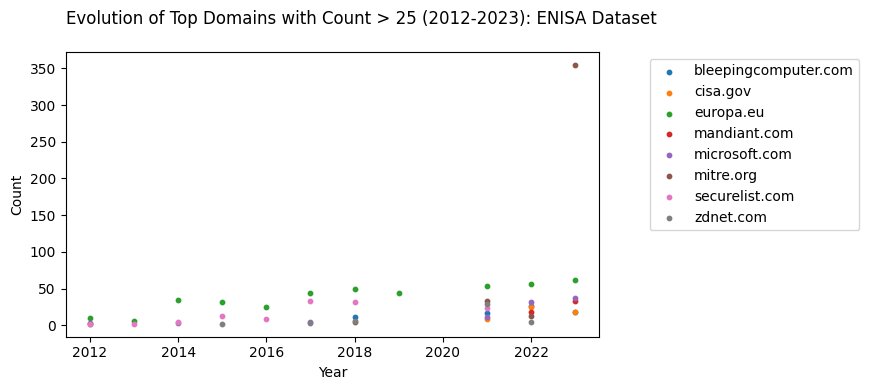

In [194]:
for file_path in file_paths:
    # Read the CSV file for the current year
    result = pd.read_csv(pdf_file_path4 + file_path)

    # Filter and get the top 5 domains for the current year
    filtered_result = result[(result['valid_domain'] == True) & (result['whois_info'].notna())]
    top_domains = filtered_result['Domain'].value_counts().head(50)
    print(top_domains)

    # Extract the year from the file path or adjust based on your data
    year = int((file_path.split(' ')[-1]).split('_')[0])

    # Store the top 5 domains for the current year in the dictionary
    top_domains_by_year[year] = top_domains

# Create a DataFrame from the dictionary
top_domains_df = pd.DataFrame(top_domains_by_year)

# Plot the evolution of the top 50 domains
plt.figure(figsize=(10, 4))
for domain in top_domains_df.index:
    #plt.plot(top_domains_df.columns, top_domains_df.loc[domain], label=domain)
    # Exclude labels for lines where the maximum count is below a threshold (e.g., 10)
    counts = top_domains_df.loc[domain]
    if counts.max() >= 25:
        plt.scatter(top_domains_df.columns, counts, label=domain, marker='o', s=10)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Evolution of Top Domains with Count > 25 (2012-2023): ENISA Dataset', loc='left', pad=20)
plt.legend()

# Get the current axes
ax = plt.gca()

# Move the legend more to the right
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1), bbox_transform=ax.transAxes)

plt.tight_layout()

# Save the plot as an image
plt.savefig(os.path.join(folder_path, 'evolution_enisa_top_domain_names_counts_plot.png'))

# Display the plot
plt.show()